In [1]:
from datascience import *
path_data = '../assets/data/'
import numpy as np

import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# 12.1 A/B Testing

두 개의 수치 샘플이 동일한 기본 분포에서 나오는지 여부를 결정하는 테스트.

### 흡연자와 비흡연자

엄마-아기 쌍에 대한 여러 정보가 있다. 이들 중, 엄마가 임신중 흡연 여부에 대한 정보도 있따.

이 분석의 목적은 산모의 흡연이 신생아의 출생 체중과 관련이 있는지를 확인하는 것이다.

In [2]:
births = Table.read_table(path_data + 'baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [3]:
smoking_and_birthweight = births.select('Maternal Smoker', 'Birth Weight')
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [4]:
smoking_and_birthweight.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


In [5]:
births.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


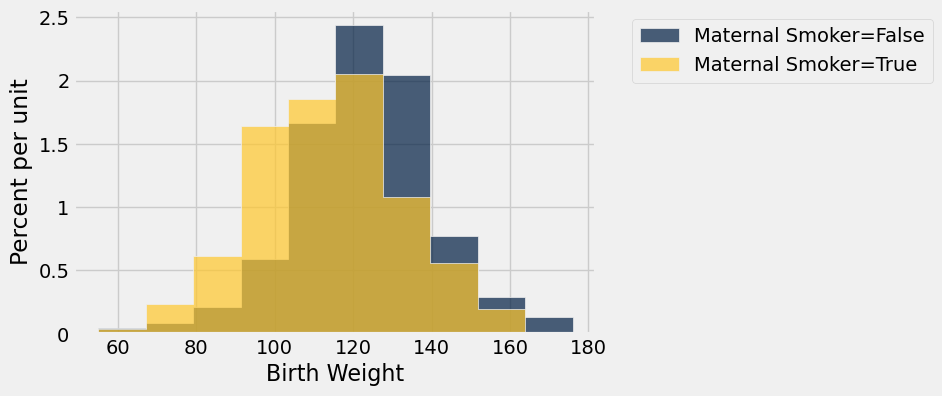

In [6]:
smoking_and_birthweight.hist('Birth Weight', group = 'Maternal Smoker')
plots.show()

흡연 산모와 비흡연 산모의 아이의 출생 체중을 나타낸 그래프다. 흡연 산모의 아이의 체중은 비흡연 산모의 아이의 체중보다 왼쪽으로 쏠려있다는 것을 볼 수 있다. 평균적으로 낮아 보인다.

이는 그 차이가 단순한 우연인지, 아니면 더 큰 인구의 집단 분포 차이를 반영하는 것인이 의문을 제기한다. 

### 가설

귀무가설 : 모집단에서 아기의 출생 체중 분포는 흡연 산모와 비흡연 산모의 아이 출생 체중 분포가 동일하다. => 표본의 차이는 우연이다.

대립가설 : 흡연 산모의 아이의 체중이 비흡연 아이의 체중 보다 더 적다. => 표본의 차이가 모집단의 분포를 따른다.

### 테스트 통계

대립가설에 의해 흡연 산모의 아이의 체중과 비흡연 산모의 아이의 체중 두 그룹 평균의 차이를 통계로 사용할 수 있다.

In [7]:
means_table = smoking_and_birthweight.group('Maternal Smoker', np.average)
means_table

Maternal Smoker,Birth Weight average
False,123.085
True,113.819


In [8]:
means = means_table.column(1)
observed_difference = means.item(1) - means.item(0)
observed_difference

-9.266142572024918

흡연자가 비흡연자보다 몸무게가 9정도 작다. (평균)

In [9]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean birth weights of the two groups"""
    reduced = table.select('Birth Weight', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [10]:
difference_of_means(births, 'Maternal Smoker')

-9.266142572024918

흡연 산모와 비흡연 산모가 무작위로 샘플링된 데이터와 기존의 데이터에서 분포의 차이가 거의 없다면 평균에서도 차이가 거의 없을것이다. 이것이 random permutation

In [11]:
smoking_and_birthweight

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136
False,138
False,132
False,120
True,143
False,140


In [12]:
shuffled_labels = smoking_and_birthweight.sample(with_replacement = False).column(0)
original_and_shuffled = smoking_and_birthweight.with_column('Shuffled Label', shuffled_labels)

In [13]:
original_and_shuffled

Maternal Smoker,Birth Weight,Shuffled Label
False,120,True
False,113,False
True,128,False
True,108,True
False,136,False
False,138,False
False,132,False
False,120,True
True,143,False
False,140,False


In [14]:
shuffled_only = original_and_shuffled.select('Birth Weight','Shuffled Label')
shuffled_group_means = shuffled_only.group('Shuffled Label', np.average)
shuffled_group_means

Shuffled Label,Birth Weight average
False,119.158
True,119.937


In [15]:
difference_of_means(original_and_shuffled, 'Shuffled Label')

0.7787772140713258

In [16]:
difference_of_means(original_and_shuffled, 'Maternal Smoker')

-9.266142572024918

기존의 흡연 산모와 비흡연 산모의 아이의 체중 차이의 평균은 -9.2였지만, 랜덤 샘플링 하여 다시 평균의 차이를 측정한 결과 0.77로 나왔다. 훨씬 가까워졌다.

In [17]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean birthweights
    of babies of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of birth weights and shuffled labels
    shuffled_table = births.select('Birth Weight').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [24]:
one_simulated_difference_of_means()

-1.0384661090543545

다른 셔플링 그룹이 더 큰 차이를 내는지를 확인하기 위해 여러 번 샘플링을 돌려보아야 한다.

### Permutation Test

In [25]:
differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)

Observed Difference: -9.266142572024918


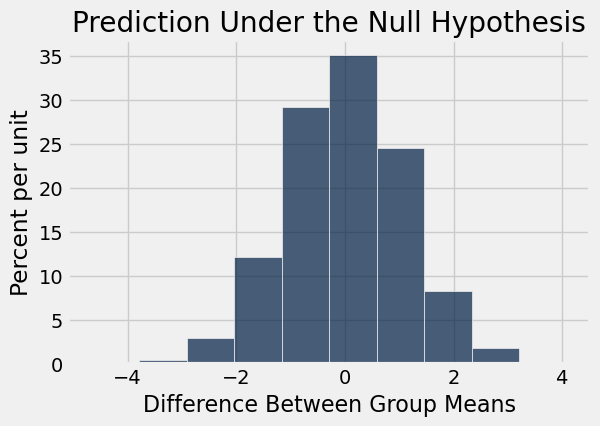

In [26]:
Table().with_column('Difference Between Group Means', differences).hist()
print('Observed Difference:', observed_difference)
plots.title('Prediction Under the Null Hypothesis')
plots.show()

총 5000번의 샘플링을 진행하였고, 0을 기준으로 정규분포를 띄는 형태를 보아 대부분의 그룹에서 두 집단의 평균 차이는 크게 나지 않은것을 알 수 있다.

In [27]:
empirical_p = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_p

0.0

p-value는 0으로 나왔다. 이는 물론 근사치이기 때문에 해당 범위에서 차이가 날 확률이 0%라는 것은 아니다. 하지만 이번 시뮬레이션에 따르면 p-value는 매우 작기 때문에 해당 귀무 가설은 기각할 수 있다.

### 다른 방법으로 test

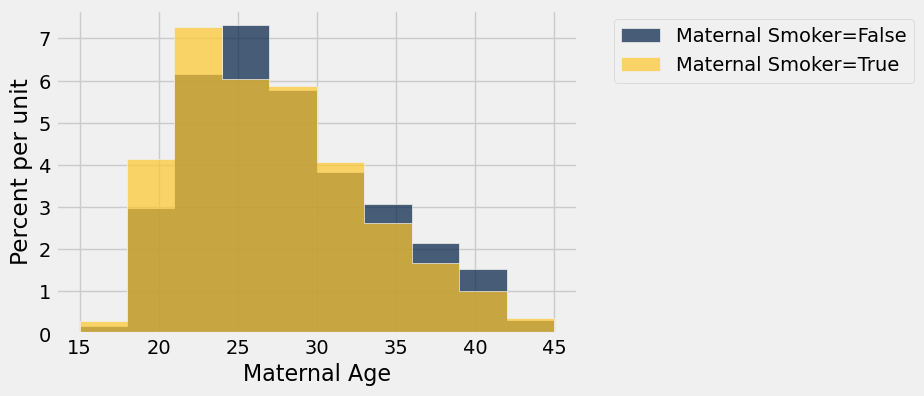

In [28]:
smoking_and_age = births.select('Maternal Smoker', 'Maternal Age')
smoking_and_age.hist('Maternal Age', group = 'Maternal Smoker')
plots.show()

흡연 산모가 비흡연 산모보다 저금 더 젊은 것을 알 수 있다.

In [29]:
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean ages of the two groups"""
    reduced = table.select('Maternal Age', group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [30]:
observed_age_difference = difference_of_means(births, 'Maternal Smoker')
observed_age_difference

-0.8076725017901509

두 집단의 나이차이는 약 0.8살이다.

마찬가지로 이 차이는 우연에 의한 것인지, 아니면 인구의 근본적인 차이를 반영한 것인지 의문을 제기할 수 있다.

이 의문또한 permutation test를 통해 질문에 답을 할 수 있다.

In [31]:
def one_simulated_difference_of_means():
    """Returns: Difference between mean ages
    of smokers and non-smokers after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = births.sample(with_replacement=False).column('Maternal Smoker')
    
    # table of ages and shuffled labels
    shuffled_table = births.select('Maternal Age').with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')   

In [32]:
age_differences = make_array()

repetitions = 5000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    age_differences = np.append(age_differences, new_difference)

In [33]:
Table().with_column(
    'Difference Between Group Means', age_differences).hist(
    right_end = observed_age_difference)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 1.2)
plots.scatter(observed_age_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_age_difference)

Observed Difference: -0.8076725017901509


In [34]:
empirical_p = np.count_nonzero(age_differences <= observed_age_difference) / 5000
empirical_p

0.0106

5000번의 샘플링을 통해 흡연 산모와 비흡연 산모의 평균 나이차를 구하였다. 이 차이가 0.8보다 큰 경우를 구해보니 전체 경우 중 약 1%정도 였다. 따라서 결과는 통계적으로 유의미하고, 이 테스트는 흡연자들이 평균적으로 더 젊다는 가설을 뒷받침한다.

## 12.2 Causality (인과관계)

In [35]:
bta = Table.read_table(path_data + 'bta.csv')
bta.show()

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [36]:
bta.group('Group', sum)

Group,Result sum
Control,2
Treatment,9


In [37]:
bta.group('Group', np.average)

Group,Result average
Control,0.125
Treatment,0.6


요통이 있는 환자 31명 중, 실제 치료약을 처방한 그룹 15명과 가짜 치료약을 처방한 그룹 16명을 구분하였다. 이들 중 호전된 환자는 9명, 2명 이었다. 비율을 나타내면 다음과 같았다.

따라서 실제 약을 처방한 그룹에서 상태 호전이 더 이루어진 것을 알 수 있는데, 이 차이는 과연 우연에 의한 것일까?

### 잠재적 결과

환자들이 두 그룹으로 배정받기 전에, 우리는 환자들에 대해 두 가지 결과를 상상할 수 있다. treatement 그룹에 배정 받으면 치료될 것이고, control 그룹에 배정 받으면 치료가 더딘 등의 결과. 이를 환자의 두 가지 잠재적 결과라 한다.

따라서 31개의 잠재적 treatement 결과와 잠재적 control 결과가 있다. 질문은 각각 31개의 결과를 가진 두 분포가 동일한지를 묻는다.

In [38]:
observed_outcomes = Table.read_table(path_data + "observed_outcomes.csv")
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


### 가설

귀무가설 : treatement와 control의 분포는 동일하다.

대립가설 : 분포는 동일하지 않다.

In [39]:
observed_proportions = bta.group('Group', np.average).column(1)
observed_distance = abs(observed_proportions.item(0) - observed_proportions.item(1))
observed_distance

0.475

In [40]:
def distance(table, group_label):
    reduced = table.select('Result', group_label)
    proportions = reduced.group(group_label, np.average).column(1)
    return abs(proportions.item(1) - proportions.item(0))

In [41]:
distance(bta, 'Group')

0.475

### 귀무가설 하에 통계량 예측하기

모든 그룹 레이블을 무작위로 permutation한 0/1을 넣는다.

In [42]:
shuffled_labels = bta.sample(with_replacement=False).column(0)

In [43]:
bta_with_shuffled_labels = bta.with_column('Shuffled Label', shuffled_labels)
bta_with_shuffled_labels.show()

Group,Result,Shuffled Label
Control,1,Control
Control,1,Control
Control,0,Treatment
Control,0,Control
Control,0,Treatment
Control,0,Treatment
Control,0,Treatment
Control,0,Treatment
Control,0,Treatment
Control,0,Treatment


In [44]:
distance(bta_with_shuffled_labels, 'Shuffled Label')

0.3

In [45]:
distance(bta_with_shuffled_labels, 'Group')

0.475

### Permutation Test

In [46]:
def one_simulated_distance():
    shuffled_labels = bta.sample(with_replacement = False
                                                    ).column('Group')
    shuffled_table = bta.select('Result').with_column(
        'Shuffled Label', shuffled_labels)
    return distance(shuffled_table, 'Shuffled Label') 

In [47]:
distances = make_array()

repetitions = 20000
for i in np.arange(repetitions):
    new_distance = one_simulated_distance()
    distances = np.append(distances, new_distance)

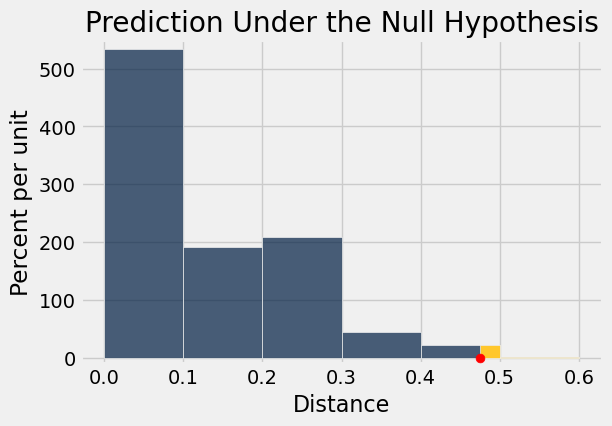

Observed Distance 0.475


In [49]:
Table().with_column('Distance', distances).hist(
    bins = np.arange(0, 0.7, 0.1), left_end = observed_distance)
# Plotting parameters; you can ignore the code below
plots.ylim(-0.1, 5.5)
plots.scatter(observed_distance, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis')
plots.show()
print('Observed Distance', observed_distance)

In [50]:
empirical_p = np.count_nonzero(distances >= observed_distance) / repetitions
empirical_p

0.01025